## [모듈 2.1] 사용자 정의 스크립트 (Bring Your Own Script) 로 모델 훈련
Using Scikit-learn with the SageMaker Python SDK
- https://sagemaker.readthedocs.io/en/stable/frameworks/sklearn/using_sklearn.html

Iris Training and Prediction with Sagemaker Scikit-learn
- https://github.com/aws/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/scikit_learn_iris/scikit_learn_estimator_example_with_batch_transform.ipynb

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np


---
## Data 다운로드 및 로딩

데이터에 대한 자세한 정보는 여기를 참조 하세요. [here](https://rdrr.io/github/robjhyndman/fpp/man/gasoline.html)


In [2]:
# !wget http://robjhyndman.com/data/gasoline.csv

,thousands_barrels
0,6621.0
1,6433.0
2,6582.0
3,7224.0
4,6875.0


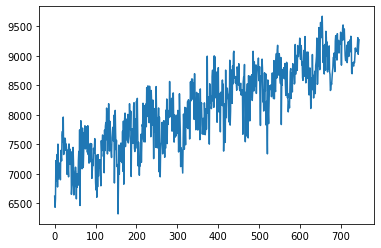

In [3]:
raw_gas = pd.read_csv('gasoline.csv', header=None, names=['thousands_barrels'])
display(raw_gas.head())
plt.plot(raw_gas)
plt.show()

## 피쳐 엔지니어링

In [4]:
def make_feature_engineering(gas):
    gas['thousands_barrels_lag1'] = gas['thousands_barrels'].shift(1)
    gas['thousands_barrels_lag2'] = gas['thousands_barrels'].shift(2)
    gas['thousands_barrels_lag3'] = gas['thousands_barrels'].shift(3)
    gas['thousands_barrels_lag4'] = gas['thousands_barrels'].shift(4)
    gas['trend'] = np.arange(len(gas))
    gas['log_trend'] = np.log1p(np.arange(len(gas)))
    gas['sq_trend'] = np.arange(len(gas)) ** 2
    weeks = pd.get_dummies(np.array(list(range(52)) * 15)[:len(gas)], prefix='week')
    gas = pd.concat([gas, weeks], axis=1)
    
    return gas

gas = make_feature_engineering(raw_gas)

## 훈련, 검증, 테스트 데이터 세트로 분리

In [5]:
train_border=0.6
test_border=0.8
n_lags = 4 ; label = 'thousands_barrels'   
gas = gas.iloc[n_lags:, ]
split_train = int(len(gas) * train_border)
split_test = int(len(gas) * test_border)

train = gas[:split_train]
val = gas[split_train:split_test]
test = gas[split_test:]
# train_X = gas.drop(label, axis=1).iloc[:split_train, ].to_numpy()
# validation_y = gas[label][split_train:split_test]
# validation_X = gas.drop(label, axis=1).iloc[split_train:split_test, ].to_numpy()
# test_y = gas[label][split_test:]

# train_y = gas[label][:split_train]
# train_X = gas.drop(label, axis=1).iloc[:split_train, ].to_numpy()
# validation_y = gas[label][split_train:split_test]
# validation_X = gas.drop(label, axis=1).iloc[split_train:split_test, ].to_numpy()
test_y = gas[label][split_test:]
test_X = gas.drop(label, axis=1).iloc[split_test:, ].to_numpy()


In [6]:
print("test_X: ", test_X.shape)
print(train.shape)
train.head(2)

test_X:  (149, 59)
(444, 60)


,thousands_barrels,thousands_barrels_lag1,thousands_barrels_lag2,thousands_barrels_lag3,thousands_barrels_lag4,trend,log_trend,sq_trend,week_0,week_1,...,week_42,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51
4,6875.0,7224.0,6582.0,6433.0,6621.0,4,1.609438,16,0,0,...,0,0,0,0,0,0,0,0,0,0
5,6947.0,6875.0,7224.0,6582.0,6433.0,5,1.791759,25,0,0,...,0,0,0,0,0,0,0,0,0,0


### 데이터 파일을 로컬 및 S3에 업로드

In [7]:
import sagemaker 

def save_local(df,dir, file_name ):
    os.makedirs(dir, exist_ok=True)
    file_name_path = os.path.join(dir, file_name)
    df.to_csv(file_name_path, index=False,  header=None, float_format='%.3f')
    print(f'{file_name_path} is saved')
    
    return file_name_path

# S3 prefix
prefix = 'Scikit-byos'
train_dir = 'fe_data/train'
train_file_path = save_local(train,dir=train_dir, file_name='train.csv' )

val_dir = 'fe_data/val'
val_file_path = save_local(val,dir=val_dir, file_name='val.csv' )

test_dir = 'fe_data/test'
test_file_path = save_local(test, dir=test_dir, file_name='test.csv' )


from p_utils import upload_s3
    
bucket = sagemaker.Session().default_bucket()
prefix = 'demandforecasting'
train_file_name = 'test/train/train.csv'
s3_train_path = upload_s3(bucket, train_file_path, prefix)
s3_val_path = upload_s3(bucket, val_file_path, prefix)
s3_test_path = upload_s3(bucket, test_file_path, prefix)


fe_data/train/train.csv is saved
fe_data/val/val.csv is saved
fe_data/test/test.csv is saved
s3_path:  s3://sagemaker-ap-northeast-2-057716757052/demandforecasting/fe_data/train/train.csv
s3_path:  s3://sagemaker-ap-northeast-2-057716757052/demandforecasting/fe_data/val/val.csv
s3_path:  s3://sagemaker-ap-northeast-2-057716757052/demandforecasting/fe_data/test/test.csv


## 모델 훈련

In [8]:
# instance_type = 'local'
instance_type="ml.c4.xlarge"

In [9]:
from sagemaker import local

if instance_type == 'local':
    sess = local.LocalSession()
else:
    sess = sagemaker.Session()

In [10]:
from sagemaker import get_execution_role

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'src/train.py'


sklearn_estimator = SKLearn(
    entry_point=script_path,
    framework_version=FRAMEWORK_VERSION,
    instance_type= instance_type,
    role=role,
    sagemaker_session= sess,
    # bhyperparameters={'max_leaf_nodes': 30}
)

In [11]:
%%time
sklearn_estimator.fit({'train': s3_train_path}, logs=False)


2020-12-03 13:18:40 Starting - Starting the training job
2020-12-03 13:18:42 Starting - Launching requested ML instances............
2020-12-03 13:19:50 Starting - Preparing the instances for training..........................
2020-12-03 13:22:04 Downloading - Downloading input data......
2020-12-03 13:22:38 Training - Downloading the training image.
2020-12-03 13:22:52 Training - Training image download completed. Training in progress...
2020-12-03 13:23:02 Uploading - Uploading generated training model
2020-12-03 13:23:09 Completed - Training job completed


## 모델 아티팩트 얻기

In [12]:
local_model_dir = 'model'
os.makedirs(local_model_dir, exist_ok=True)
s3_model_dir = sklearn_estimator.model_data

In [13]:
!aws s3 cp {s3_model_dir} {local_model_dir}/model.tar.gz
!tar -xzf {local_model_dir}/model.tar.gz -C {local_model_dir}

download: s3://sagemaker-ap-northeast-2-057716757052/sagemaker-scikit-learn-2020-12-03-13-18-40-289/output/model.tar.gz to model/model.tar.gz


In [14]:
# local_model_path = os.path.join(local_model_dir, 'model.joblib')
%store s3_model_dir
%store test_file_path
%store local_model_dir

Stored 's3_model_dir' (str)
Stored 'test_file_path' (str)
Stored 'local_model_dir' (str)
